# Изучение YOLO V5 - Быстре методы обнаружения объектов.
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1d--jyNUIyCfu7kqCzS_axSZTuJZFUID8#scrollTo=EFAO3VOrllIY)


In [ ]:
import torch
model = torch.hub.load('ultralytics/yolov5', 'yolov5s', pretrained=True)


%cd /content/
!git clone https://github.com/ultralytics/yolov5  # clone
%cd yolov5
%pip install -qr requirements.txt  # install

try:
    import yolov5
except:
    pass


import os
os.kill(os.getpid(), 9)

/usr/local/lib/python3.10/dist-packages/torch/hub.py:294: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(
Downloading: "https://github.com/ultralytics/yolov5/zipball/master" to /root/.cache/torch/hub/master.zip


requirements: Ultralytics requirements ['gitpython>=3.1.30', 'Pillow>=10.0.1'] not found, attempting AutoUpdate...
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.6/190.6 kB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 25.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 286.5 MB/s eta 0:00:00
  Attempting uninstall: Pillow
    Found existing installation: Pillow 9.4.0
    Uninstalling Pillow-9.4.0:
      Successfully uninstalled Pillow-9.4.0

requirements: AutoUpdate success ✅ 7.4s, installed 2 packages: ['gitpython>=3.1.30', 'Pillow>=10.0.1']
requirements: ⚠️ Restart runtime or rerun command for updates to take effect



YOLOv5 🚀 2023-12-21 Python-3.10.12 torch-2.1.0+cu121 CUDA:0 (Tesla T4, 15102MiB)

100%|██████████| 14.1M/14.1M [00:00<00:00, 187MB/s]

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients, 16.4 GFLOPs
Adding AutoShape... 


/content
Cloning into 'yolov5'...
remote: Enumerating objects: 16114, done.
remote: Counting objects: 100% (25/25), done.
remote: Compressing objects: 100% (24/24), done.
remote: Total 16114 (delta 8), reused 10 (delta 1), pack-reused 16089
Receiving objects: 100% (16114/16114), 14.85 MiB | 19.11 MiB/s, done.
Resolving deltas: 100% (11031/11031), done.
/content/yolov5


Попытаемся импортировать скаченный репозиторий. Для этого перейдем в соответствующую директорию при помощи команды `%cd /content/yolov5` и попытаемся импортировать библиотеку утилит.

Отметим, что помимо команд командной строки вы можете поменять директорию при помощи

In [1]:
%cd /content/yolov5

import torch
from yolov5 import utils
display = utils.notebook_init()  # checks

YOLOv5 🚀 v7.0-253-g63555c8 Python-3.10.12 torch-2.1.0+cu121 CUDA:0 (Tesla T4, 15102MiB)


Setup complete ✅ (2 CPUs, 12.7 GB RAM, 26.3/78.2 GB disk)


Содержение репозитория может быть проверено при помощи команд bash

In [2]:
!pwd
!ls

/content/yolov5
benchmarks.py	 data	     LICENSE	      requirements.txt	tutorial.ipynb
CITATION.cff	 detect.py   models	      segment		utils
classify	 export.py   README.md	      setup.cfg		val.py
CONTRIBUTING.md  hubconf.py  README.zh-CN.md  train.py


Теперь проведем импорт основных библиотек.

In [3]:
import os
import shutil
import torch
import random
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline
import cv2
import matplotlib.patches as patches
from google.colab.patches import cv2_imshow


In [4]:
def torch_stats():
    torch_version = ".".join(torch.__version__.split(".")[:2])
    print('PyTorch version:',torch_version)

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print('Using device:', device)
    dtype = torch.float32

    if device.type == 'cuda':
        cuda_version  = torch.__version__.split("+")[-1]
        print("Cuda: ", cuda_version)

        torch.set_default_tensor_type(torch.cuda.FloatTensor)
        print('Cuda is available:',torch.cuda.is_available())

        n_devices = torch.cuda.device_count()
        print('number of devices: %d'%(n_devices))

        for cnt_device in range(n_devices):
            print(torch.cuda.get_device_name(cnt_device))
            print('Memory Usage:')
            print('Allocated:', round(torch.cuda.memory_allocated(cnt_device)/1024**3,1), 'GB')
            print('Cached:   ', round(torch.cuda.memory_reserved(cnt_device)/1024**3,1), 'GB')


    torch.set_default_dtype(dtype) # float32
    print('Default data type:',dtype)

    num_workers=os.cpu_count() #torch.get_num_threads()
    print ('Available number of workers:',num_workers)

    return device, dtype, num_workers
#-------------------------------
def torch_seed(seed = 42, deterministic = True):
    random.seed(seed) # random and transforms
    np.random.seed(seed) #numpy
    torch.manual_seed(seed) #cpu
    torch.cuda.manual_seed(seed) #gpu
    torch.backends.cudnn.deterministic=deterministic #cudnn

In [5]:
torch.cuda.empty_cache()
device, dtype, num_workers = torch_stats()
torch_seed(seed = 42, deterministic = True)

PyTorch version: 2.1
Using device: cuda
Cuda:  cu121
Cuda is available: True
number of devices: 1
Tesla T4
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB
Default data type: torch.float32
Available number of workers: 2


Перед тем, как обучить модель, давайте скачаем набор данных.

In [6]:
from urllib.request import urlretrieve
from torchvision.datasets.utils import download_and_extract_archive

In [7]:
url = "https://github.com/matterport/Mask_RCNN/releases/download/v2.1/balloon_dataset.zip"

root_directory = os.path.join(os.getcwd(),'/content/data')

archive_name = url.split('/')[-1]
dataset_directory = os.path.join(root_directory, archive_name)
# dataset_directory = os.path.splitext(dataset_directory)[0]
dataset_directory = os.path.join(root_directory, 'balloon')

download_and_extract_archive(url, root_directory)

100%|██████████| 38741381/38741381 [00:00<00:00, 87010207.82it/s]


Extracting /content/data/balloon_dataset.zip to /content/data


In [8]:
import json

def balloon2yolo(xmin,ymin, xmax, ymax, image_width, image_height):
    x = (xmin + xmax)/2.0/image_width
    y = (ymin + ymax)/2.0/image_height
    w = (xmax - xmin)/image_width
    h = (ymax - ymin)/image_height
    return x,y,w,h

def yolo2coco(xc, yc, w, h, image_width, image_height):
    xc, w = xc*image_width,  w*image_width
    yc, h = yc*image_height, h*image_height
    xmin = xc - w//2
    ymin = yc - h//2
    return xmin,ymin,w, h

def create_anno(img_dir):
    anno_path = os.path.join(img_dir, 'via_region_data.json')
    with open(anno_path) as f:
        imgs_anns = json.load(f)
    img_pths = []
    ann_pths = []
    for idx, ann in enumerate(imgs_anns.values()):
        file_image = os.path.join(img_dir, ann["filename"])
        file_ann = os.path.splitext(file_image)[0]+'.txt'
        img_pths +=[file_image]
        ann_pths +=[file_ann]
        height, width = np.asarray(Image.open(file_image)).shape[:2]
        annos = ann["regions"]
        string = ''
        for _, anno in annos.items():
            assert not anno["region_attributes"]
            anno = anno["shape_attributes"]
            px = anno["all_points_x"]
            py = anno["all_points_y"]
            xmin, xmax  = np.min(px), np.max(px)
            ymin, ymax  = np.min(py), np.max(py)
            x,y,w,h = balloon2yolo(xmin,ymin, xmax, ymax, width, height)
            category_id = 0
            content =f"{category_id} {x} {y} {w} {h}\n"
            string = string + content
        with open(file_ann, 'w') as f:
            f.write(string[:-1])#without last '\n' symbol
    return img_pths, ann_pths

Проверим, что директории созданы правильно и создадим аннотации. Функция `create_anno` возвращает списки путей к изображениям и путей к их аннотациям.

In [9]:
val_dir   = os.path.join(dataset_directory, 'val')
train_dir = os.path.join(dataset_directory, 'train')

val_img,     val_ann = create_anno(val_dir)
train_img, train_ann = create_anno(train_dir)

print('train length:\t',len(train_img),  '\nval length:\t',len(val_img))

train length:	 61 
val length:	 13


Попробуем визуализировать результат создания набора данных. Для этого напишем функцию считывающую разметку из аннотаций формата `YOLO`. А также создадим функцию `plot_bbox` для визуализации.

In [10]:
def get_ann(ann_pth):
    with open(ann_pth, 'r') as f:
        data = f.read()
    return [list(map(float, string.split(' '))) for string in data.split('\n')]

In [11]:
data = get_ann(val_ann[1])
print(np.asarray(data)[:,1:])

[[     0.4069     0.13623     0.14583      0.1084]
 [    0.53418       0.125     0.11654    0.041992]
 [    0.53027     0.18042     0.15169      0.1167]
 [    0.60026     0.29004    0.091146     0.11133]
 [    0.53027     0.28979     0.16211     0.14111]
 [    0.39518     0.23511     0.15234     0.14014]
 [    0.43229     0.33398     0.13151    0.085938]]


In [12]:
def plot_bbox(image_pth, ann_pth = None):
    image =  np.asarray(Image.open(image_pth))

    height, width = image.shape[:2]

    if ann_pth is None:
        ann_pth = os.path.splitext(image_pth)[0]+'.txt'
    bbox   = np.asarray(get_ann(ann_pth))[:,1:]

    fig, axs = plt.subplots(1, 2, figsize = (8,4))
    image_ = np.copy(image).astype(float)/image.max()

    # Ground Truth
    axs[0].imshow(np.clip(image_,0,1), 'gray')
    axs[0].axis('off'); axs[0].set_title('Original Image')
    #----------------------------

    # Object Detection BBoxes
    axs[1].imshow(np.clip(image_,0,1), 'gray')
    for box in bbox:
        xmin,ymin,w,h = yolo2coco(*box, width,height)
        bb = patches.Rectangle(xy     = (xmin,ymin),
                               width  = w,height = h,
                               linewidth=2, edgecolor="blue", facecolor="none")
        axs[1].add_patch(bb)
    axs[1].axis('off'); axs[1].set_title('Object Detection')

    plt.tight_layout()
    plt.show()

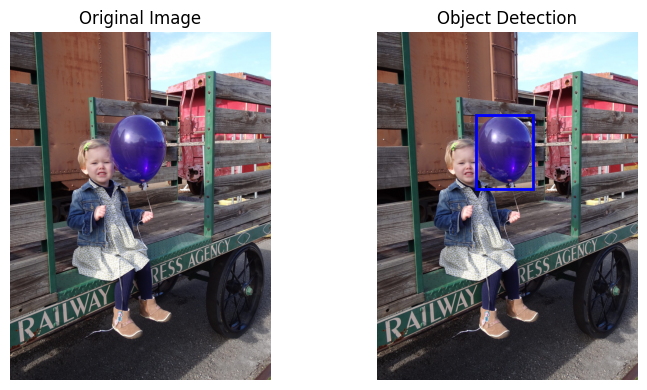

In [13]:
plot_bbox(train_img[2])

## 1. Проверьте точность нескольких моделей `yolov5` для набора balloon.

Рассмотрим модель yolov5m (число параметров 21.2М)

/content/yolov5
detect: weights=['yolov5m.pt'], source=/content/data/balloon/train/24362039530_b151b41a52_k.jpg, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.63, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_csv=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=True, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-249-gf400bba Python-3.10.12 torch-2.1.0+cu118 CUDA:0 (Tesla T4, 15102MiB)

100% 40.8M/40.8M [00:00<00:00, 289MB/s]

Fusing layers... 
YOLOv5m summary: 290 layers, 21172173 parameters, 0 gradients, 48.9 GFLOPs
image 1/1 /content/data/balloon/train/24362039530_b151b41a52_k.jpg: 640x480 1 person, 51.5ms
Speed: 0.6ms pre-process, 51.5ms inference, 115.1ms NMS per image at shape (1, 3, 640, 640)
Results saved to runs/detect/exp


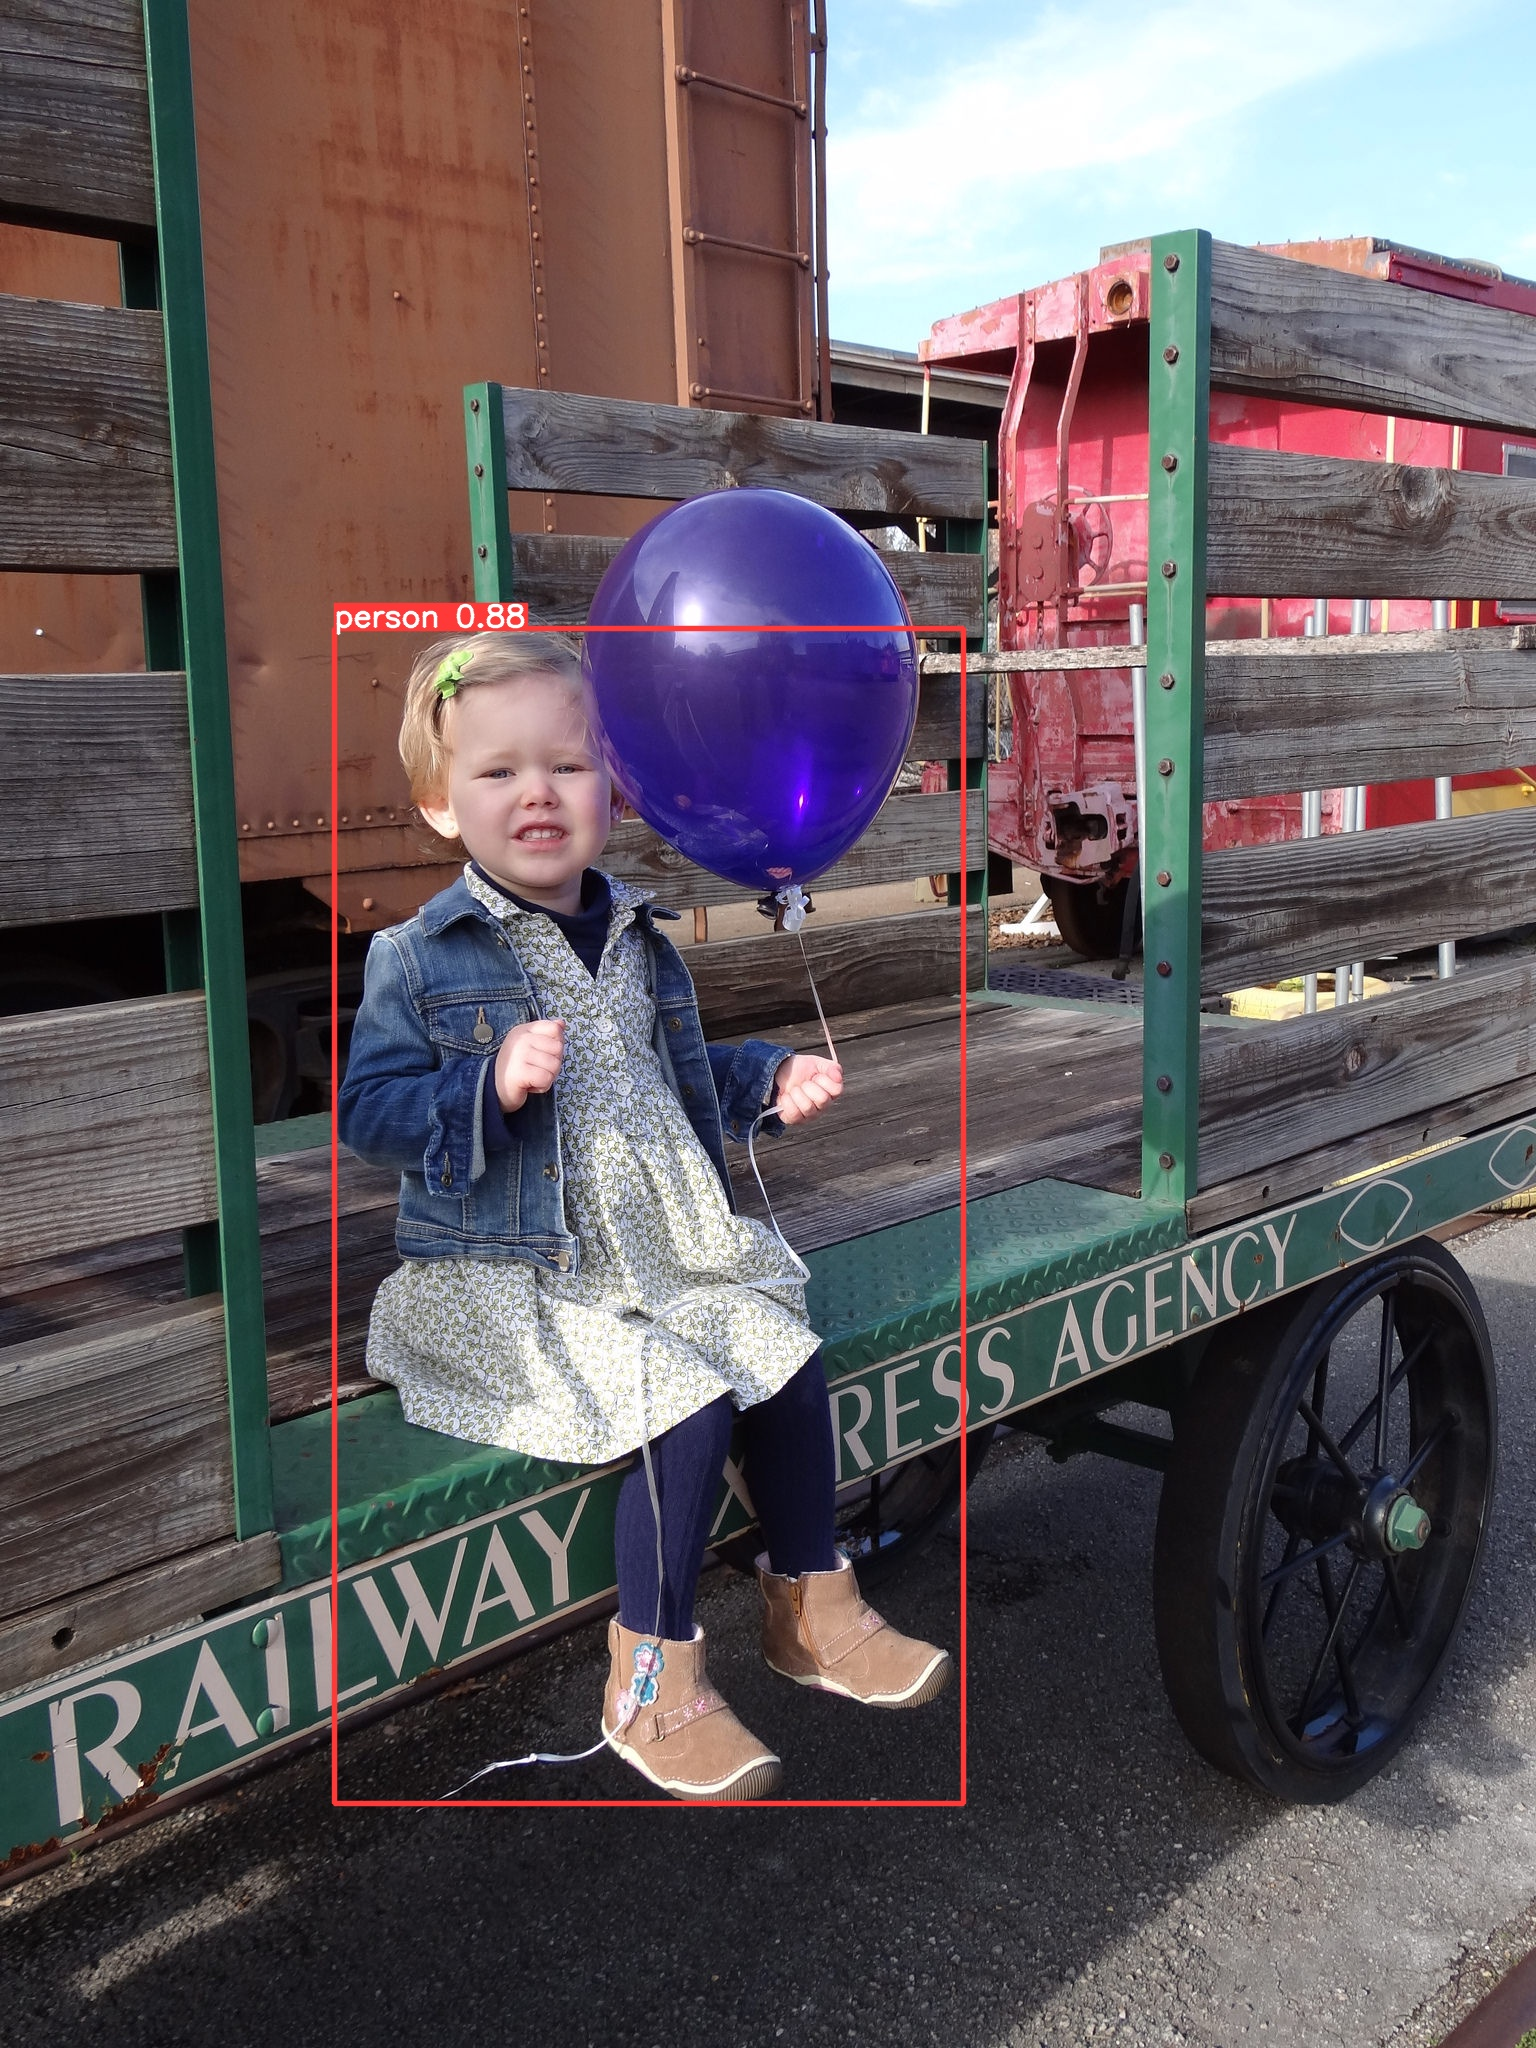

In [ ]:
%cd /content/yolov5/
!python detect.py --weights yolov5m.pt --img 640 --conf 0.63 --source '/content/data/balloon/train/24362039530_b151b41a52_k.jpg' --exist-ok

display.Image(filename='/content/yolov5/runs/detect/exp/24362039530_b151b41a52_k.jpg', width=240)

In [ ]:
data_yaml_path = os.path.join('/content/data/balloon','data_.yaml' )

string = '''names:
- '0'
nc: 1
train: /content/data/balloon/train
val: /content/data/balloon/val
'''
with open(data_yaml_path,'w') as f:
  f.writelines(string)
  f.close()

In [ ]:
!rm -rf /content/yolov5/runs/*

In [ ]:
%cd /content/yolov5/

!python train.py --img 640 --batch 16 --epochs 30 --data /content/data/balloon/data_.yaml --weights yolov5m.pt --exist-ok

/content/yolov5
2023-12-14 12:36:07.821769: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-14 12:36:07.821827: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-14 12:36:07.821866: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
train: weights=yolov5m.pt, cfg=, data=/content/data/balloon/data_.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=30, batch_size=16, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SG

/content/yolov5


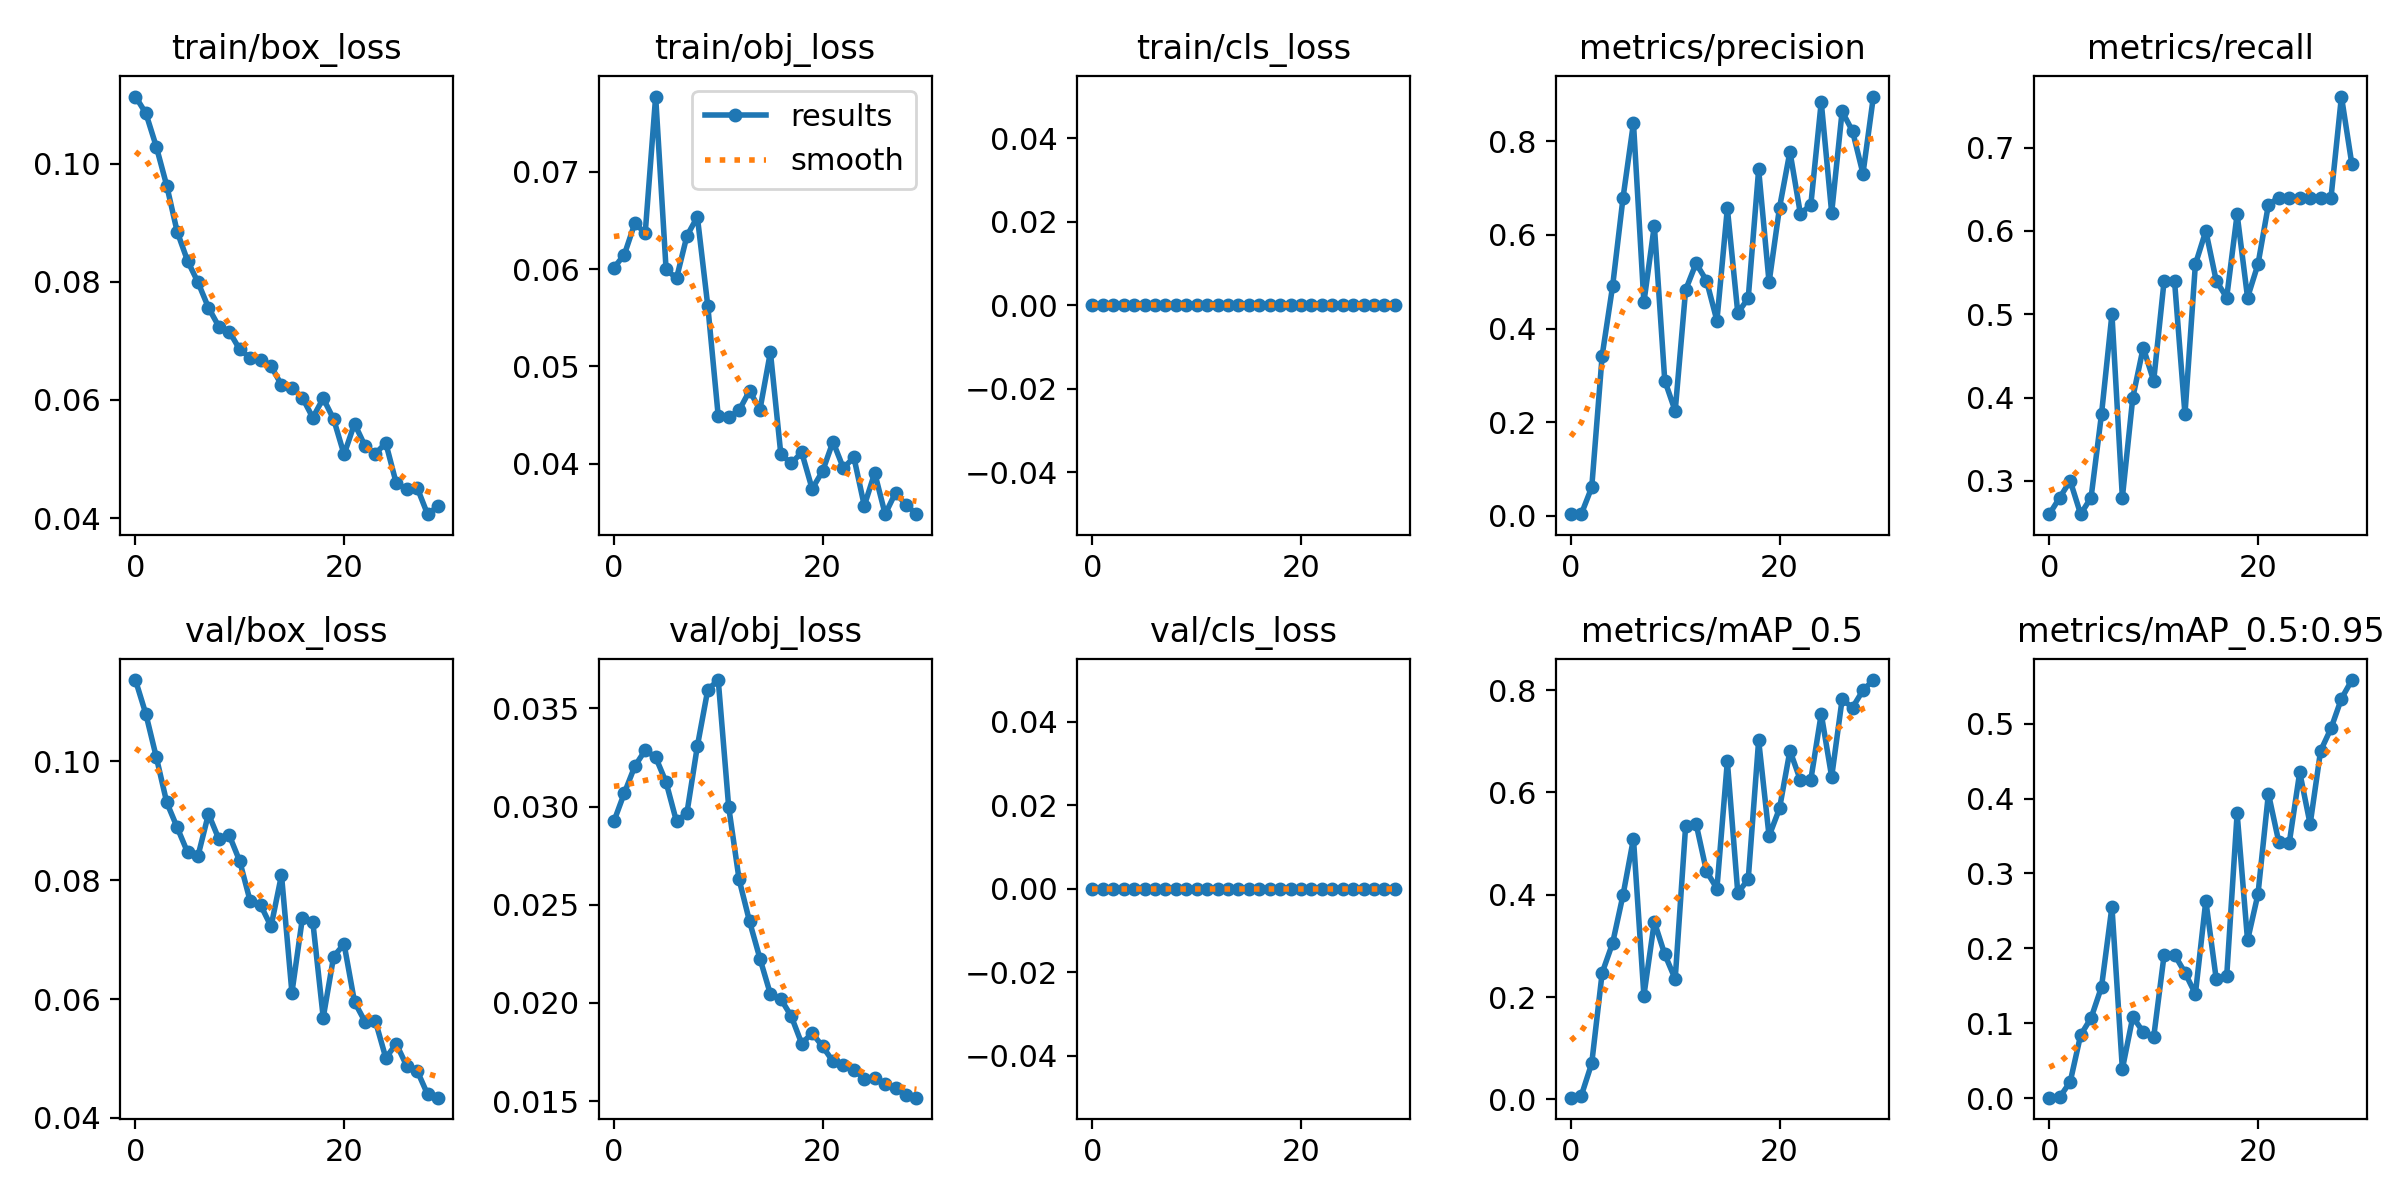

In [ ]:
%cd /content/yolov5/
from utils.plots import plot_results
plot_results('/content/yolov5/runs/train/exp/results.csv')  # plot 'results.csv' as 'results.png'
display.Image(filename='/content/yolov5/runs/train/exp/results.png', width=640)

In [ ]:
!python val.py --weights /content/yolov5/runs/train/exp/weights/best.pt --data /content/data/balloon/data_.yaml --img 640  --iou-thres 0.15 --conf-thres 0.65 --exist-ok

val: data=/content/data/balloon/data_.yaml, weights=['/content/yolov5/runs/train/exp/weights/best.pt'], batch_size=32, imgsz=640, conf_thres=0.65, iou_thres=0.15, max_det=300, task=val, device=, workers=8, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=runs/val, name=exp, exist_ok=True, half=False, dnn=False
WARNING ⚠️ confidence threshold 0.65 > 0.001 produces invalid results
YOLOv5 🚀 v7.0-249-gf400bba Python-3.10.12 torch-2.1.0+cu118 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
Model summary: 212 layers, 20852934 parameters, 0 gradients, 47.9 GFLOPs
val: Scanning /content/data/balloon/val.cache... 13 images, 0 backgrounds, 0 corrupt: 100% 13/13 [00:00<?, ?it/s]
                 Class     Images  Instances          P          R      mAP50   mAP50-95: 100% 1/1 [00:01<00:00,  1.82s/it]
                   all         13         50      0.943       0.66      0.818      0.599
Speed: 0.2ms pre-process, 24.4ms in

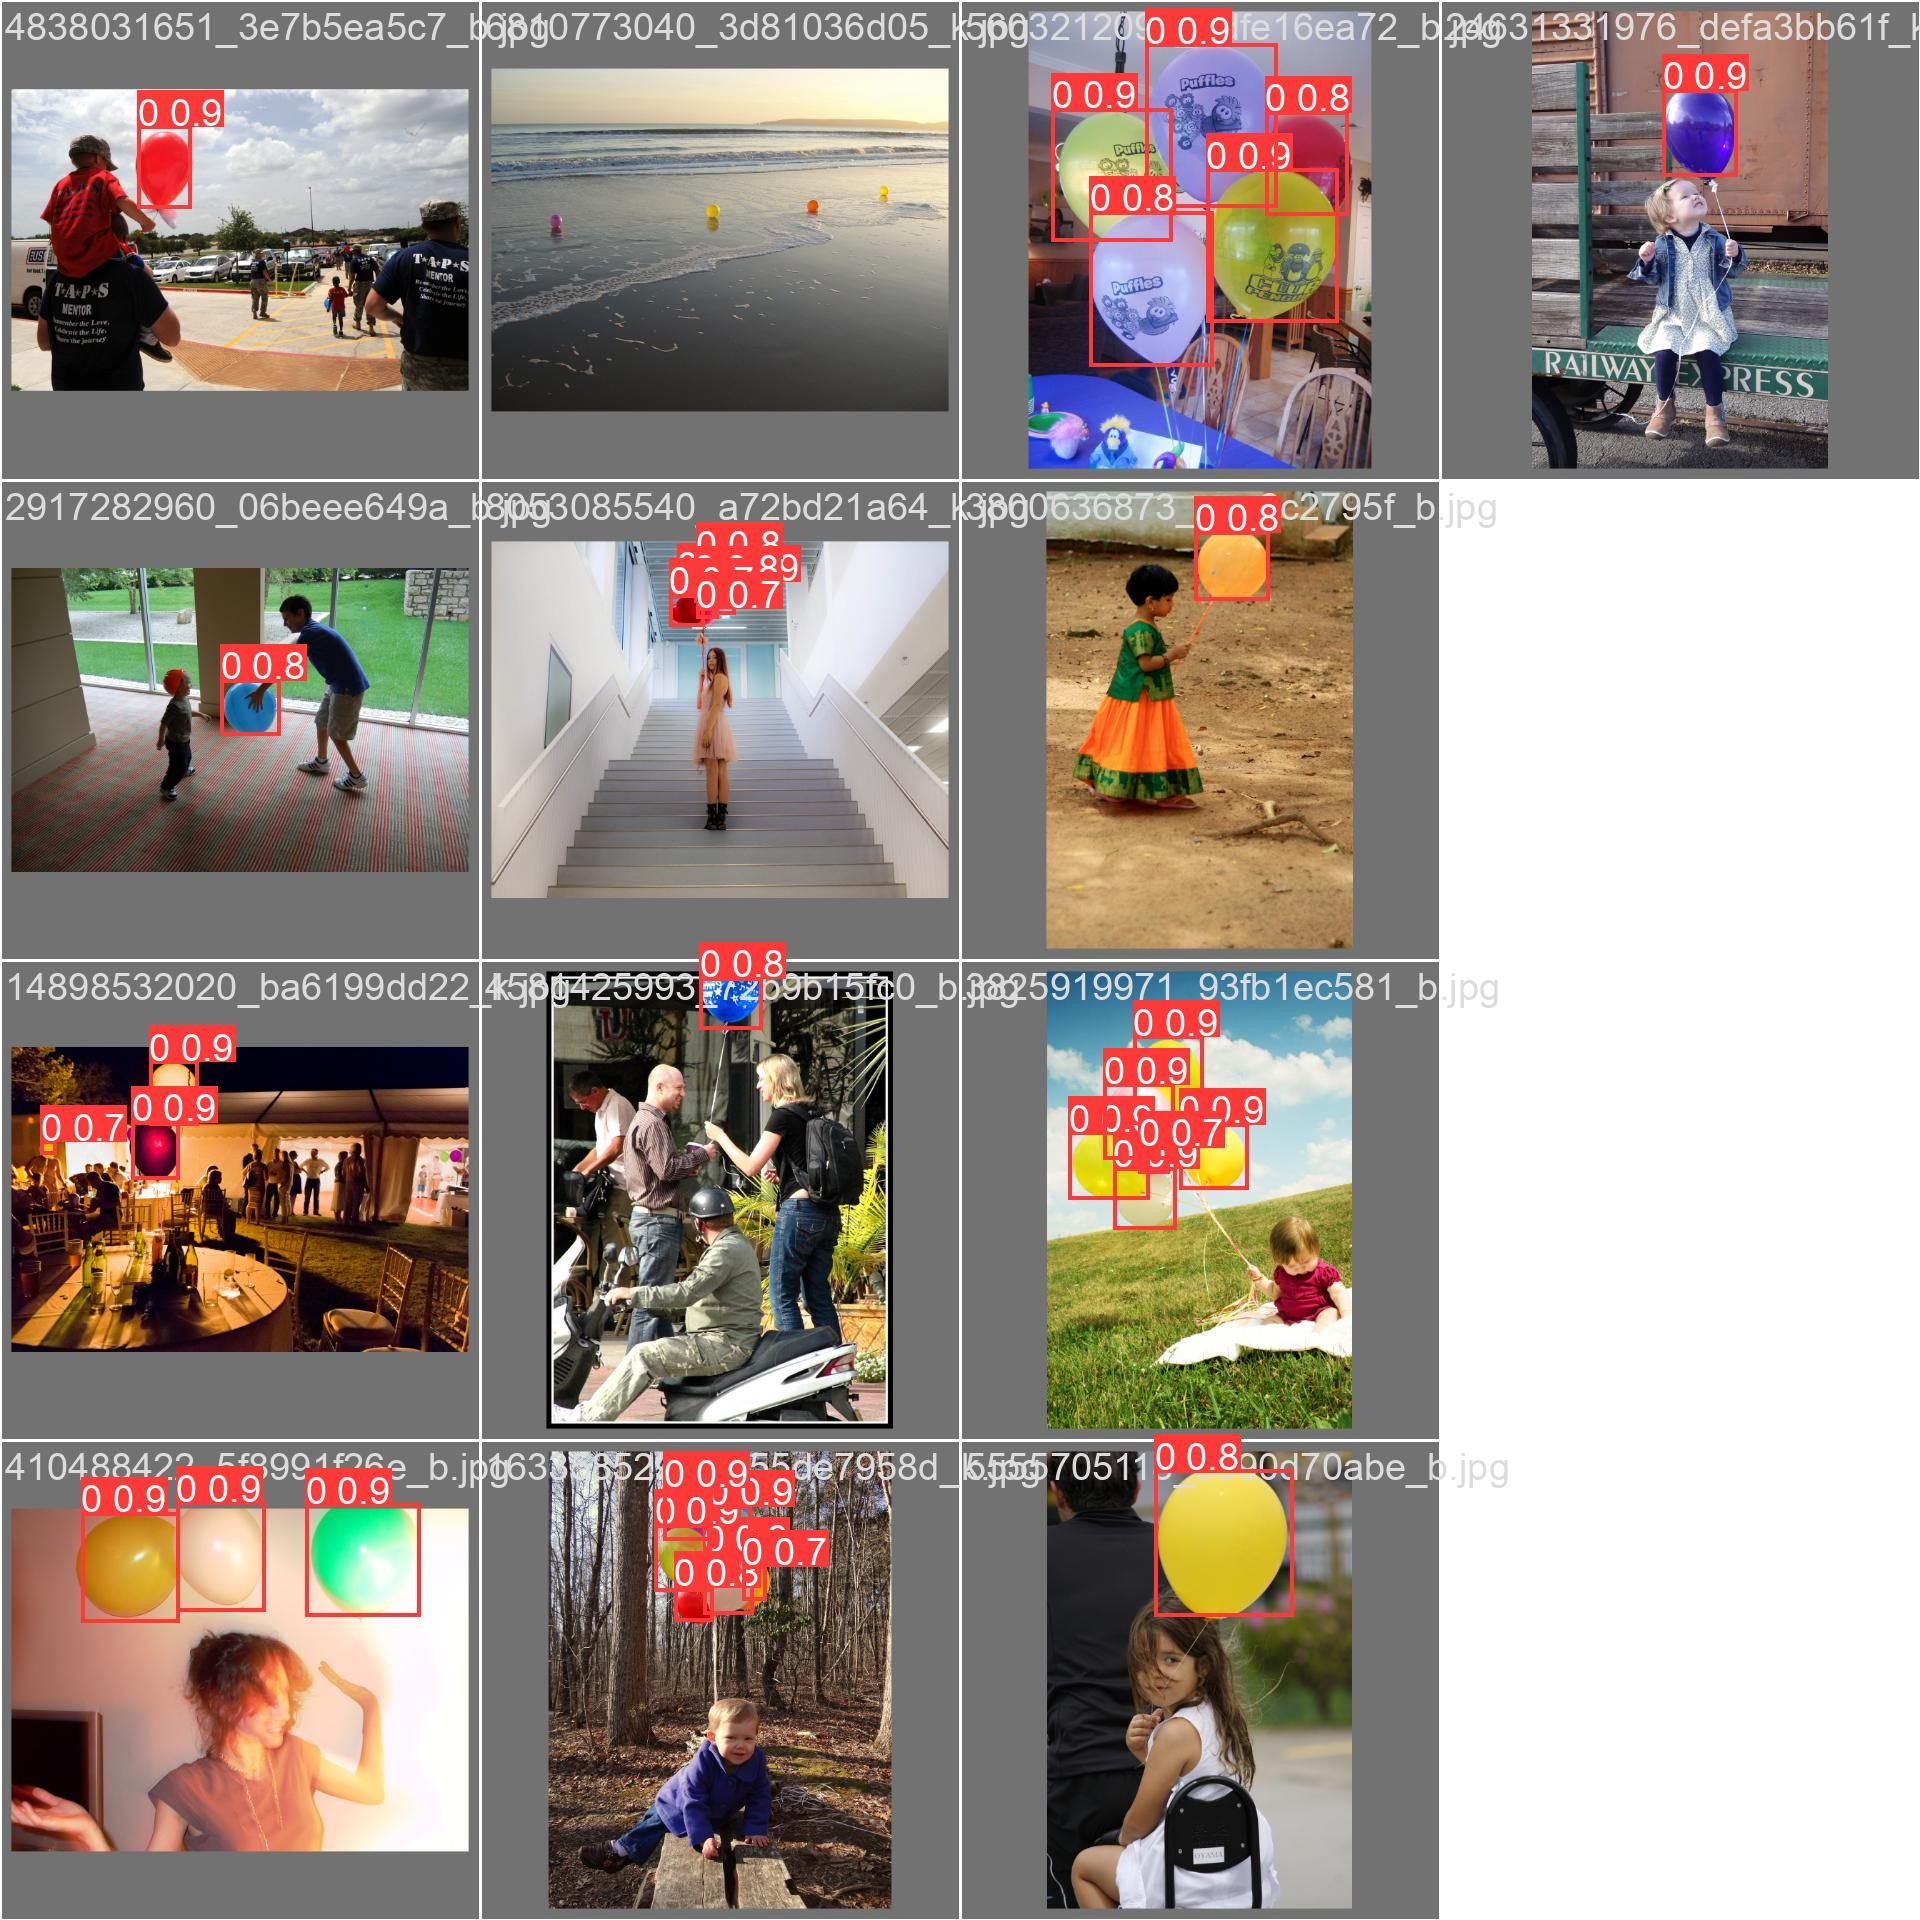

In [ ]:
display.Image(filename='/content/yolov5/runs/val/exp/val_batch0_pred.jpg', width=540)

Видно, что модель хорошо находит искомые объекты - шарики, причем с высокой уверенностью

Теперь рассмотрим модель yolov5m6.pt (число параметров 35.7М)

/content/yolov5
detect: weights=['yolov5m6.pt'], source=/content/data/balloon/train/24362039530_b151b41a52_k.jpg, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.63, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_csv=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=True, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-249-gf400bba Python-3.10.12 torch-2.1.0+cu118 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
YOLOv5m6 summary: 378 layers, 35704908 parameters, 0 gradients, 49.9 GFLOPs
image 1/1 /content/data/balloon/train/24362039530_b151b41a52_k.jpg: 640x512 1 person, 63.4ms
Speed: 0.7ms pre-process, 63.4ms inference, 82.6ms NMS per image at shape (1, 3, 640, 640)
Results saved to runs/detect/exp


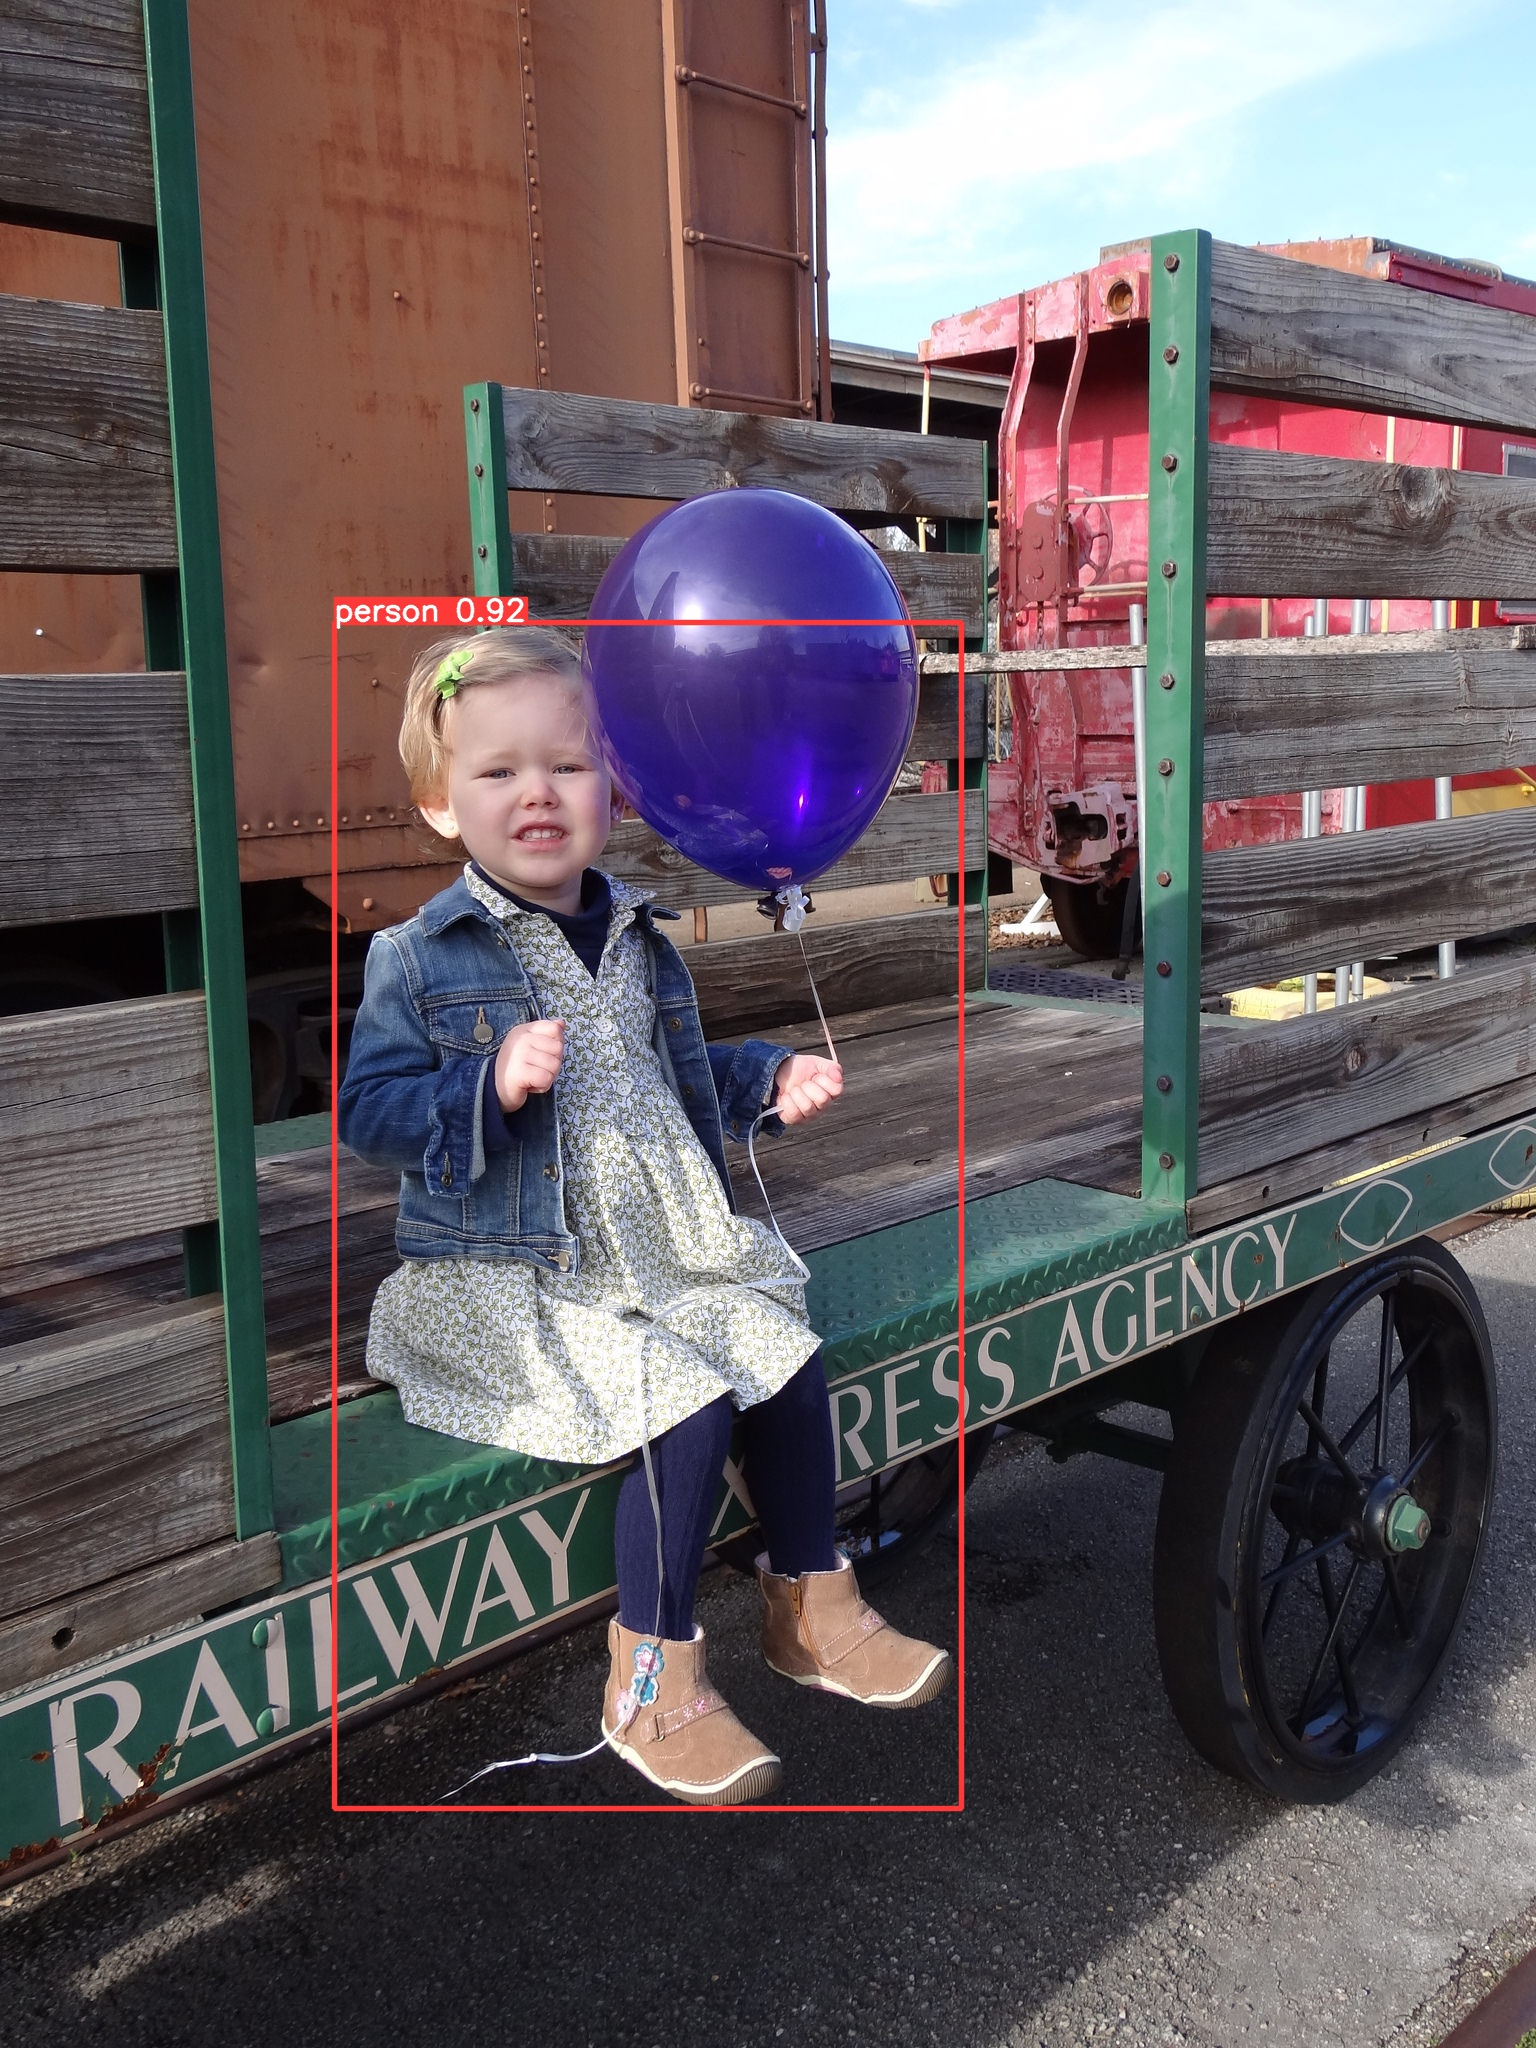

In [ ]:
%cd /content/yolov5/
!python detect.py --weights yolov5m6.pt --img 640 --conf 0.63 --source '/content/data/balloon/train/24362039530_b151b41a52_k.jpg' --exist-ok

display.Image(filename='/content/yolov5/runs/detect/exp/24362039530_b151b41a52_k.jpg', width=240)

In [ ]:
data_yaml_path = os.path.join('/content/data/balloon','data_.yaml' )

string = '''names:
- '0'
nc: 1
train: /content/data/balloon/train
val: /content/data/balloon/val
'''
with open(data_yaml_path,'w') as f:
  f.writelines(string)
  f.close()

In [ ]:
!rm -rf /content/yolov5/runs/*

In [ ]:
%cd /content/yolov5/

!python train.py --img 640 --batch 16 --epochs 30 --data /content/data/balloon/data_.yaml --weights yolov5m6.pt --exist-ok

/content/yolov5
2023-12-14 12:47:28.402070: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-14 12:47:28.402138: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-14 12:47:28.402188: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
train: weights=yolov5m6.pt, cfg=, data=/content/data/balloon/data_.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=30, batch_size=16, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=S

/content/yolov5


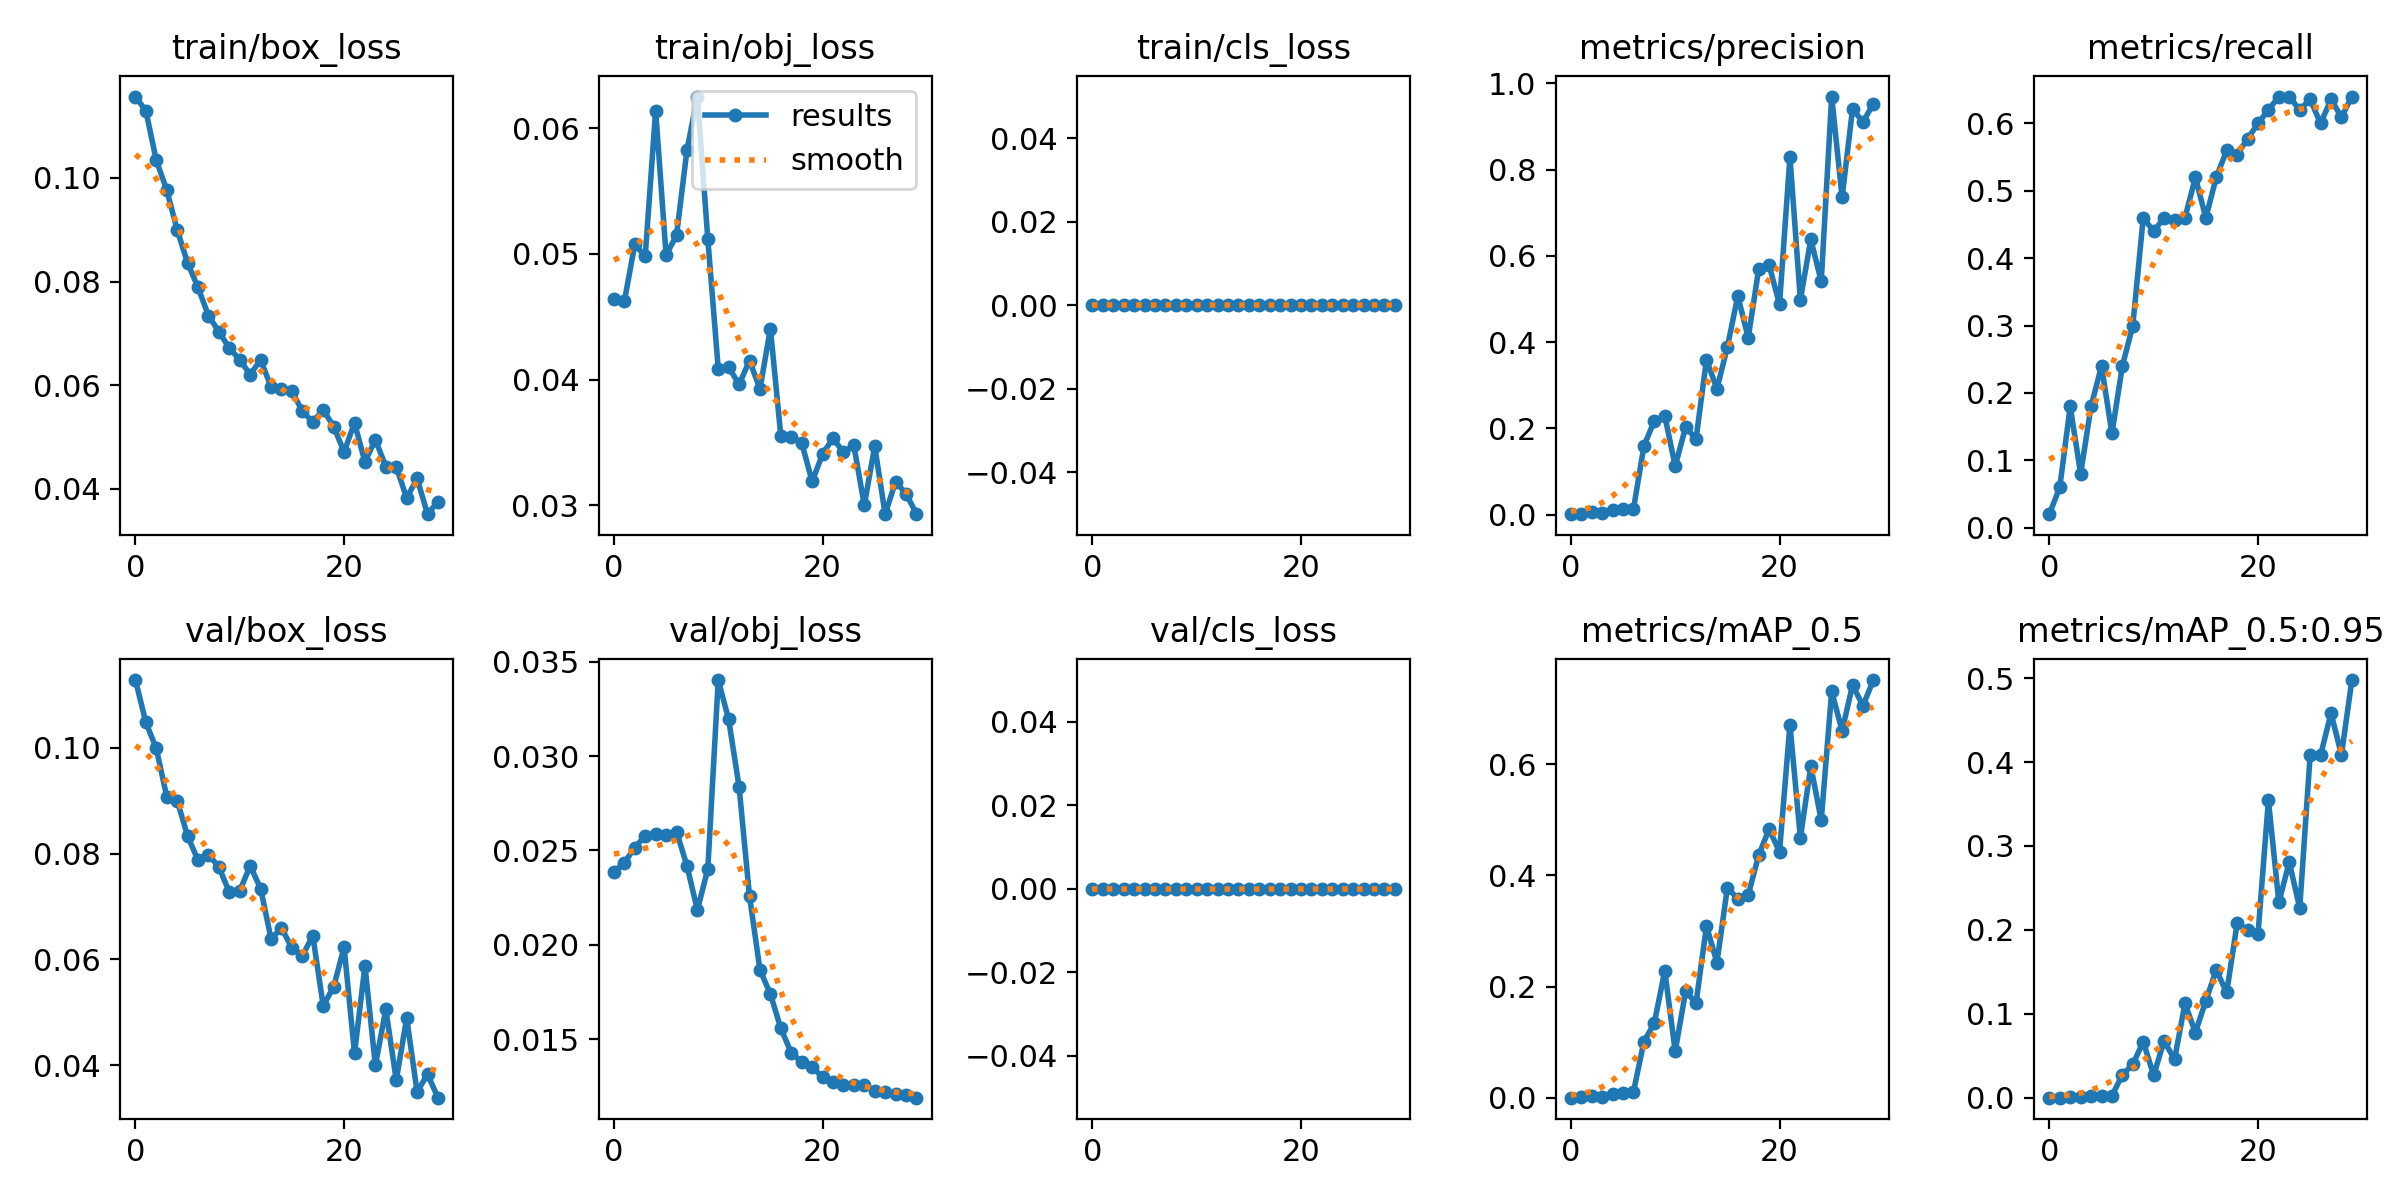

In [ ]:
%cd /content/yolov5/
from utils.plots import plot_results
plot_results('/content/yolov5/runs/train/exp/results.csv')  # plot 'results.csv' as 'results.png'
display.Image(filename='/content/yolov5/runs/train/exp/results.png', width=640)

In [ ]:
!python val.py --weights /content/yolov5/runs/train/exp/weights/best.pt --data /content/data/balloon/data_.yaml --img 640  --iou-thres 0.15 --conf-thres 0.65 --exist-ok

val: data=/content/data/balloon/data_.yaml, weights=['/content/yolov5/runs/train/exp/weights/best.pt'], batch_size=32, imgsz=640, conf_thres=0.65, iou_thres=0.15, max_det=300, task=val, device=, workers=8, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=runs/val, name=exp, exist_ok=True, half=False, dnn=False
WARNING ⚠️ confidence threshold 0.65 > 0.001 produces invalid results
YOLOv5 🚀 v7.0-249-gf400bba Python-3.10.12 torch-2.1.0+cu118 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
Model summary: 276 layers, 35248920 parameters, 0 gradients, 48.9 GFLOPs
val: Scanning /content/data/balloon/val.cache... 13 images, 0 backgrounds, 0 corrupt: 100% 13/13 [00:00<?, ?it/s]
                 Class     Images  Instances          P          R      mAP50   mAP50-95: 100% 1/1 [00:01<00:00,  1.78s/it]
                   all         13         50      0.969       0.62      0.804      0.582
Speed: 0.2ms pre-process, 23.1ms in

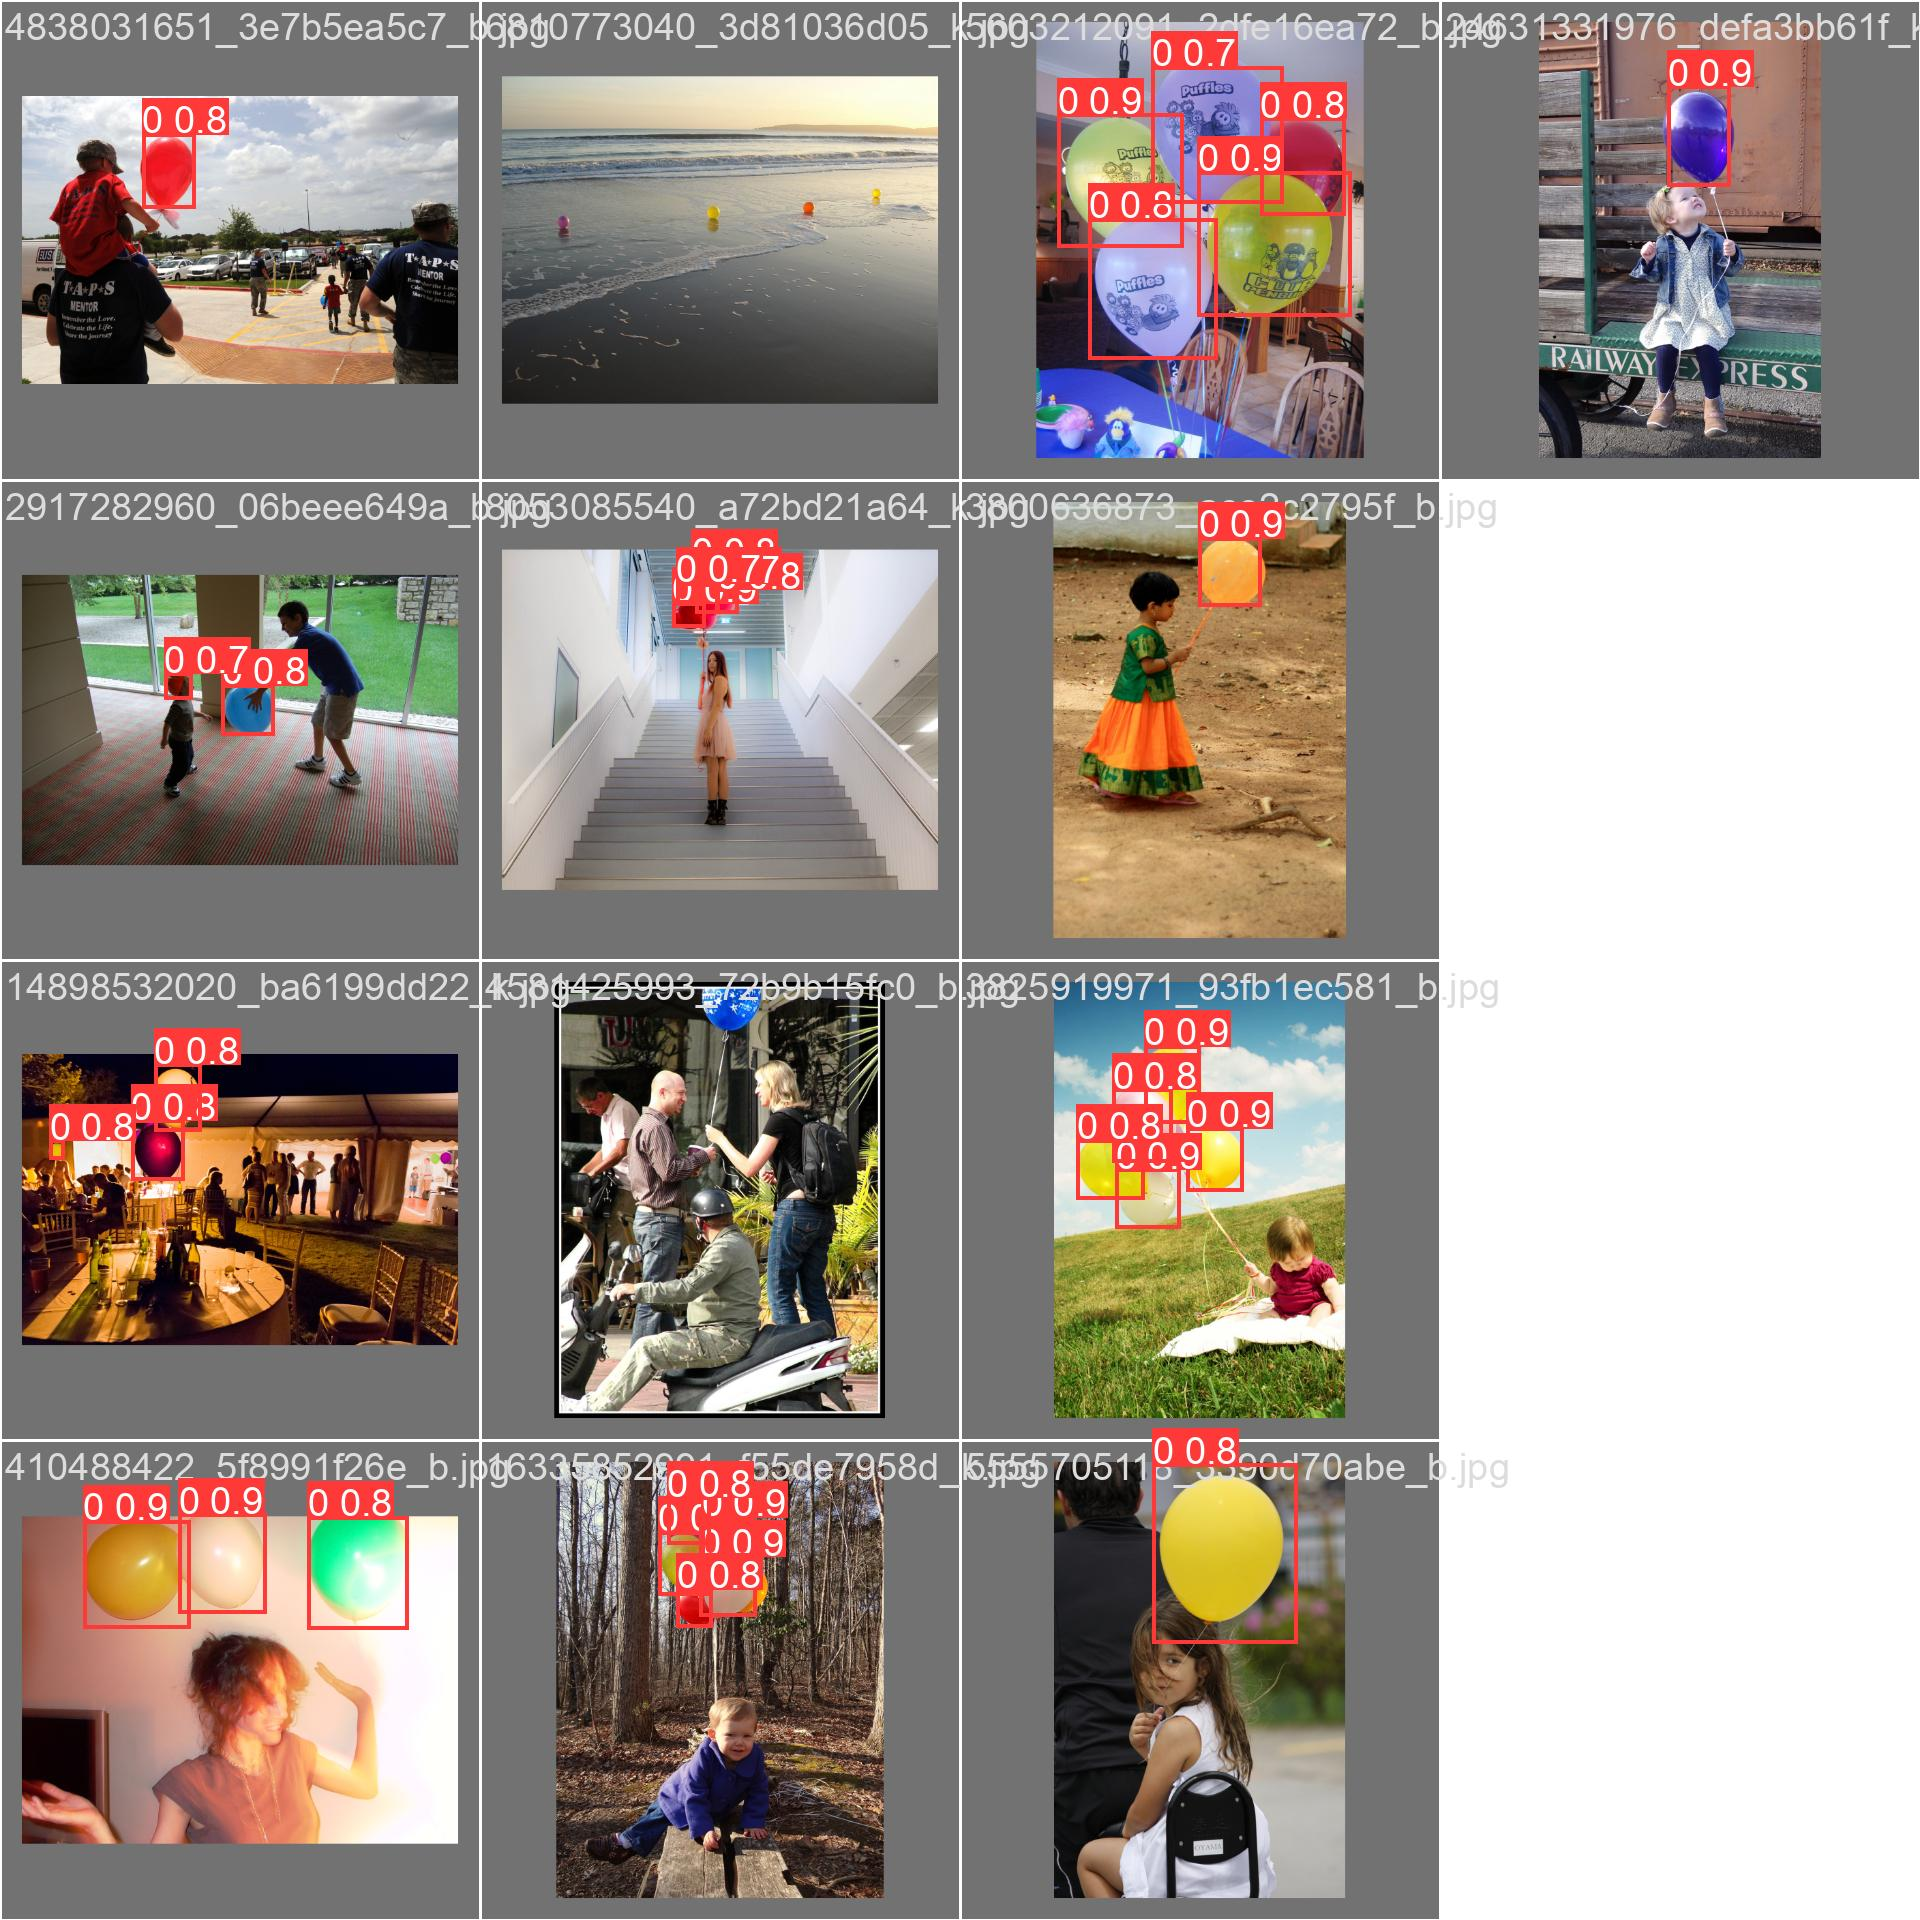

In [ ]:
display.Image(filename='/content/yolov5/runs/val/exp/val_batch0_pred.jpg', width=540)

Мы обучили модель на наших данных и теперь она достаточно уверенно находит шарики

## 2. Найдите в models/hub модели yolov3 и проверьте их для набора balloon.

In [ ]:
model = torch.hub.load('ultralytics/yolov3', 'yolov5s', pretrained=True)

Using cache found in /root/.cache/torch/hub/ultralytics_yolov3_master
YOLOv5 🚀 v7.0-253-g63555c8 Python-3.10.12 torch-2.1.0+cu121 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


In [ ]:
# Image
imgs = val_img[:2]
# Inference
results = model(imgs, 640, augment=True)

In [ ]:
results

YOLOv3 <class 'models.common.Detections'> instance
image 1/2: 2048x1323 1 person
image 2/2: 2048x1536 1 person
Speed: 65.9ms pre-process, 21.8ms inference, 1.6ms NMS per image at shape (2, 3, 640, 480)

In [ ]:
results.print()
print('Pandas XYXY')
print(results.pandas().xyxyn)

image 1/2: 2048x1323 1 person
image 2/2: 2048x1536 1 person
Speed: 65.9ms pre-process, 21.8ms inference, 1.6ms NMS per image at shape (2, 3, 640, 480)


Pandas XYXY
[       xmin      ymin      xmax      ymax  confidence  class    name
0  0.320981  0.358136  0.718307  0.950595    0.915821      0  person,        xmin      ymin      xmax      ymax  confidence  class    name
0  0.102447  0.540402  0.665633  0.992069    0.934544      0  person]


Рассмотрим для другой модели

In [ ]:
model = torch.hub.load('ultralytics/yolov3', 'yolov5m6', pretrained=True)

Using cache found in /root/.cache/torch/hub/ultralytics_yolov3_master
YOLOv5 🚀 v7.0-253-g63555c8 Python-3.10.12 torch-2.1.0+cu121 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
YOLOv5m6 summary: 378 layers, 35704908 parameters, 0 gradients
Adding AutoShape... 


In [ ]:
# Image
imgs = val_img[:2]
# Inference
results = model(imgs, 640, augment=True)

In [ ]:
results

YOLOv3 <class 'models.common.Detections'> instance
image 1/2: 2048x1323 1 person, 1 bench
image 2/2: 2048x1536 1 person
Speed: 38.7ms pre-process, 119.4ms inference, 1.2ms NMS per image at shape (2, 3, 640, 512)

In [ ]:
results.print()
print('Pandas XYXY')
print(results.pandas().xyxyn)

image 1/2: 2048x1323 1 person, 1 bench
image 2/2: 2048x1536 1 person
Speed: 38.7ms pre-process, 119.4ms inference, 1.2ms NMS per image at shape (2, 3, 640, 512)


Pandas XYXY
[       xmin      ymin      xmax      ymax  confidence  class    name
0  0.321321  0.360179  0.732565  0.951996    0.933286      0  person
1  0.000000  0.159167  0.984813  0.982859    0.452040     13   bench,        xmin      ymin      xmax      ymax  confidence  class    name
0  0.086197  0.539018  0.654651  0.966243    0.906058      0  person]


Видно, что модель находит людей причем с ввысокой точностью, а также нашла скамейку